#  Fuzzy c-means clustering

## Data generation and setup

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

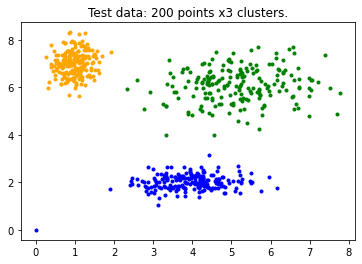

In [42]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy.cluster as cluster

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

## Clustering

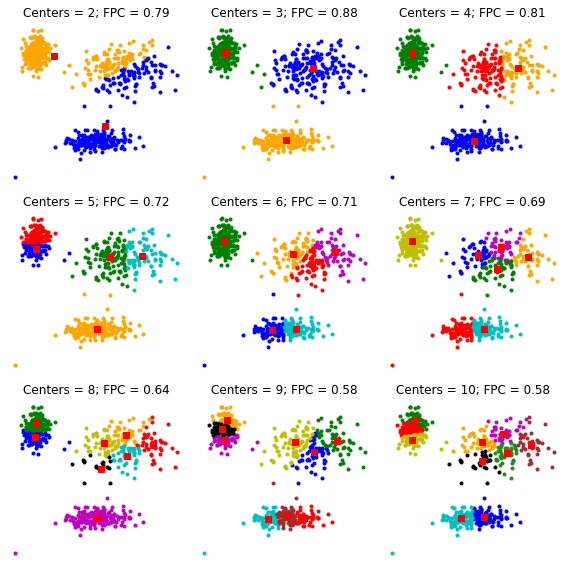

In [43]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

## The fuzzy partition coefficient (FPC)

Text(0, 0.5, 'Fuzzy partition coefficient')

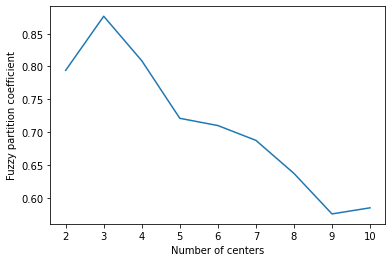

In [44]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

## Using subtractive clustering

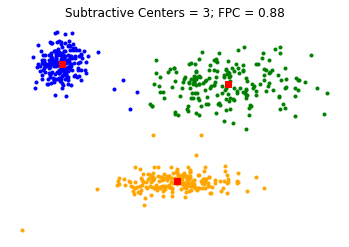

In [45]:
cntr, u, u0, d, jm, p, fpc = cluster.cmeans(
        alldata, None, 2, error=0.005, maxiter=1000, init=None, subtractive_clustering_influence_range=3)

ncenters = len(cntr)
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig4, ax4 = plt.subplots()

for j in range(ncenters):
    ax4.plot(xpts[cluster_membership == j],
            ypts[cluster_membership == j], '.', color=colors[j])

for pt in cntr:
    ax4.plot(pt[0], pt[1], 'rs')

ax4.set_title('Subtractive Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
ax4.axis('off')

plt.show()

## Classifying New Data

### Building the model

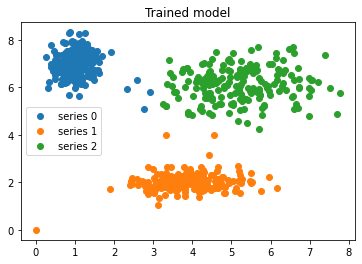

In [56]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = cluster.cmeans(
    alldata, None, 2, error=0.005, maxiter=1000, subtractive_clustering_influence_range=3)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(len(cntr)):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

### Prediction

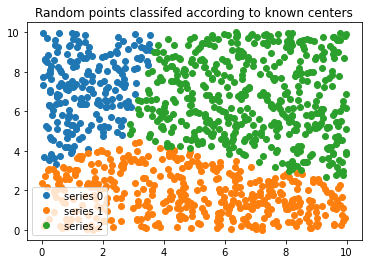

In [57]:
# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
u, u0, d, jm, p, fpc = cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(len(cntr)):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## Subtractive clustering

Summary of the data set
                0           1           2
count  600.000000  600.000000  600.000000
mean     0.531283    0.526721    0.504300
std      0.266259    0.268509    0.270036
min     -0.052928   -0.092150   -0.127443
25%      0.274196    0.267525    0.258353
50%      0.591036    0.594601    0.513759
75%      0.753673    0.736444    0.741487
max      1.023937    1.032520    1.145781 

K-means cluster centers
c1 = [0.59625457 0.1930039  0.50783814] 
c2 = [0.79543239 0.78950593 0.19570064] 
c3 = [0.20412292 0.59564128 0.8078616 ]

Subtractive cluster centers
          0         1         2
0  0.221996  0.593681  0.811270
1  0.779720  0.819054  0.180125
2  0.591420  0.172150  0.487198
c1 = [0.221996 0.593681 0.81127 ] 
c2 = [0.77972  0.819054 0.180125] 
c3 = [0.59142  0.17215  0.487198]


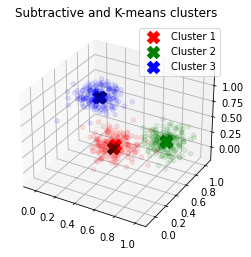

In [48]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Bhavesh Kumar'

from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

colors_options = 'rgb'

def set_colors(labels, colors=colors_options):
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels


DataFrame = pd.read_csv('clustering_dataset.csv', header=None)
# DataMatrix = DataFrame.as_matrix() deprected
DataMatrix = DataFrame.values

# normalized_data_matrix = skp.scale(DataMatrix, axis=0)
normalized_data_matrix = DataMatrix

kmeans = KMeans(n_clusters=3).fit(normalized_data_matrix)
labels = kmeans.labels_

colors = set_colors(labels)
centroids = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(normalized_data_matrix[:, 0], normalized_data_matrix[:, 1], normalized_data_matrix[:, 2], c=colors,
           alpha=0.1)
for idx, centroid in enumerate(centroids):
    ax.scatter(*centroid, c=colors_options[idx], s=150, marker='X', label='Cluster '+str(idx+1))

#plt.title('K-means Clusters')
# plt.show()

print('Summary of the data set')
print(DataFrame.describe(), '\n')

print('K-means cluster centers')
print('c1 = {} \nc2 = {} \nc3 = {}\n'.format(kmeans.cluster_centers_[0],
                                         kmeans.cluster_centers_[1],
                                         kmeans.cluster_centers_[2]))

cluster_center = cluster.subtractive_clustering(normalized_data_matrix.T, ra=0.5)

print('Subtractive cluster centers')
print(pd.DataFrame(cluster_center))
print('c1 = {} \nc2 = {} \nc3 = {}'.format(cluster_center[0],
                                           cluster_center[1],
                                           cluster_center[2]))

# plot centers produced by subtractive cluster algorithm
for idx, centroid in enumerate(cluster_center):
    ax.scatter(*centroid, c='k', s=150, marker='X')
plt.title('Subtractive and K-means clusters')
ax.legend()
plt.show()